Feature Extraction and Testing and Training set Creation.

In [1]:
import numpy as np 
import pandas as pd 
import librosa 
import os
from sklearn.model_selection import train_test_split
import sklearn
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import CSVLogger
from sklearn.preprocessing import OneHotEncoder
#from keras.callbacks import CSVLogger

#from keras.callbacks import CSVLogger

We will traverse through all the files and create a data frame containg Actor,Gender, Emotion and File Path for each audio files. Then we will use this dataframe to go through all the file path and get the mean mfccs values for each audio file. This mfcc value extracted for each audio file is used to train the model based on emotion associated with each audio file. 

In [4]:
emotion=[]
gender=[]
actor=[]
file_path=[]
for i in os.listdir('./Audio'):
    # print(i)
    for j in os.listdir('./Audio/'+i):
        # print(j)
        # Splitting the File name
        part = j.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        if int(part[6])%2:
            gender.append('male')
        else:
            gender.append("female")
        file_path.append('./Audio/' + i + '/' + j)

# A dataframe containing all emotion, gender, actor, path
new_df = pd.DataFrame(emotion)
new_df = new_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
new_df = pd.concat([pd.DataFrame(gender), new_df,pd.DataFrame(actor)], axis=1)
new_df.columns = ['gender','emotion','actor']
new_df = pd.concat([new_df, pd.DataFrame(file_path, columns = ['path'])],axis=1)
print(new_df)


      gender   emotion  actor                                       path
0       male   neutral      1  ./Audio/Actor_01/03-01-01-01-01-01-01.wav
1       male   neutral      1  ./Audio/Actor_01/03-01-01-01-01-02-01.wav
2       male   neutral      1  ./Audio/Actor_01/03-01-01-01-02-01-01.wav
3       male   neutral      1  ./Audio/Actor_01/03-01-01-01-02-02-01.wav
4       male      calm      1  ./Audio/Actor_01/03-01-02-01-01-01-01.wav
...      ...       ...    ...                                        ...
1435  female  surprise     24  ./Audio/Actor_24/03-01-08-01-02-02-24.wav
1436  female  surprise     24  ./Audio/Actor_24/03-01-08-02-01-01-24.wav
1437  female  surprise     24  ./Audio/Actor_24/03-01-08-02-01-02-24.wav
1438  female  surprise     24  ./Audio/Actor_24/03-01-08-02-02-01-24.wav
1439  female  surprise     24  ./Audio/Actor_24/03-01-08-02-02-02-24.wav

[1440 rows x 4 columns]


MFCC values for each audio file is extracted here. Generally, librosa.feature.mfcc returns us the mfcc of each audio file and is of shape 20 x 143 . So taking mean for each row using np.mean we get 20 mean mfcc values associated with each audio file. These 20 MFCC value will be used as training parameter.

In [6]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC
# New df with column name 'MFCC'
df = pd.DataFrame(columns=['MFCC'])
count=0
for path in new_df.path:
    # Load audio and set the duration to 2.75sec so that we get MFCC array of same shape
    X, sample_rate = librosa.load(path, duration=2.75)
    # MFCC
    # n_fcc is for number of properties in MFCC array
    mfccs = librosa.feature.mfcc(X, sr = sample_rate, hop_length=512, n_mfcc=20)
    # Get the mean of columns
    mean = np.mean(mfccs.T, axis = 0)
    df.loc[count] = [mean]

    count = count+1
df.head()

,MFCC
0,"[-666.3476, 65.67248, -0.28546765, 14.705958, ..."
1,"[-657.2162, 67.10929, -2.6288135, 19.595482, 1..."
2,"[-661.5828, 68.86064, -0.46880877, 16.265572, ..."
3,"[-661.4031, 64.017494, 2.1174219, 14.93825, 7...."
4,"[-680.4659, 75.32324, 0.0764176, 17.657768, 8...."


In [7]:
df['MFCC'].shape, df['MFCC'][0].shape

((1440,), (20,))

There are 1440 audio files so we get total ((1440,),(20,)) total as our dataset.  Now we combine this df with existing data frame containing other details of audio files. As we are training on mfccs values so that acts as X(input parameter) based on it's corresponding emotions values so this will act as Y(output parameter). We have divided train and test data in 0.7 : 0.3 ratio. 

In [13]:
# df contains MFCC column and audio_df which contains other labels
combined_df = pd.concat([new_df, df], axis=1)
combined_df.head()
ddff = pd.concat([combined_df['gender'], combined_df['emotion']], axis=1)
ddff = np.array(ddff)
# Dividing dataset in training and testing set
train_X, test_X, train_y, test_y = train_test_split(combined_df['MFCC'], combined_df['gender'], test_size=0.3, random_state=0)

train_X=pd.DataFrame(train_X.values.tolist())
test_X=pd.DataFrame(test_X.values.tolist())
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)


(1008, 20) (432, 20) (1008,) (432,)


Data Preprocessing

In [14]:
# Normalize Data
mean = np.mean(train_X, axis=0)
#print(mean.shape)
std = np.std(train_X, axis=0)
train_X = (train_X - mean)/std
test_X = (test_X - mean)/std

#np array
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)

#one_hot encode
encoder = OneHotEncoder()
train_y = np.array(train_y).reshape(-1,1)
test_y = np.array(test_y).reshape(-1,1)
train_y= encoder.fit_transform(train_y).toarray()
test_y = encoder.fit_transform(test_y).toarray()
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)

#scaler fit
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)


(1008, 20) (432, 20) (1008,) (432,)
(1008, 20) (432, 20) (1008, 2) (432, 2)
(1008, 20) (432, 20) (1008, 2) (432, 2)


In [15]:
#to plot

def plot_history(history):
  # function to plot accuracy vs epoch
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')



Now we will define a model, and then run the model on the test train set we have created

In [16]:
def build_mlp_model(input_shape=(20,), num_class=8):
    
    
    model=keras.models.Sequential([keras.layers.Dropout(0.1),
                                    keras.layers.Dense(512,activation='relu',input_shape=(train_X.shape[1],)),
                                    keras.layers.Dropout(0.1),
                                    keras.layers.Dense(512,activation='relu'),
                                    keras.layers.Dropout(0.1),
                                    keras.layers.Dense(128,activation='relu'),
                                    keras.layers.Dense(64,activation='relu'),
                                    keras.layers.Dense(train_y.shape[1],activation='softmax')
                                    ])

    return model

First we will train this MLP model on 'categorical_crossentropy'as loss function, and 'adam' as optimizer and check the accuracy.

In [17]:
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)
model=build_mlp_model()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('model_history.log', separator=',', append=False)

history=model.fit(train_X,train_y, epochs=1000, batch_size=256, validation_data=(test_X,test_y), callbacks=[csv_logger])
model.summary()


77 - val_accuracy: 0.9815
Epoch 872/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0568 - val_accuracy: 0.9838
Epoch 873/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0058 - accuracy: 0.9970 - val_loss: 0.0521 - val_accuracy: 0.9861
Epoch 874/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9861
Epoch 875/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0103 - accuracy: 0.9960 - val_loss: 0.0662 - val_accuracy: 0.9838
Epoch 876/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0789 - val_accuracy: 0.9815
Epoch 877/1000
4/4 [==============================] - 0s 22ms/step - loss: 5.6581e-04 - accuracy: 1.0000 - val_loss: 0.0873 - val_accuracy: 0.9838
Epoch 878/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss:

14/14 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9907


[0.04512011259794235, 0.9907407164573669]

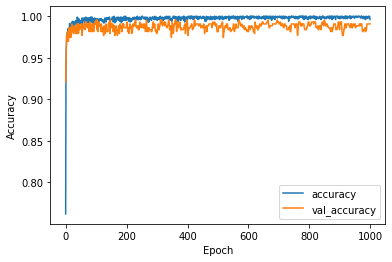

In [18]:
plot_history(history)
model.evaluate(test_X, test_y)